<a href="https://colab.research.google.com/github/cswcjt/Deep_Learning/blob/main/LSTM101_Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM을 활용한 주가 예측 모델

이번 튜토리얼 에서는 다음과 같은 **프로세스 파이프라인**으로 주가 예측을 진행합니다.

- FinanceDataReader를 활용하여 주가 데이터 받아오기
- TensorFlow Dataset 클래스를 활용하여 주가 데이터 구축
- LSTM 을 활용한 주가 예측 모델 구축

## 필요한 모듈 import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent 

## 데이터 (FinanceDataReader)

**FinanceDataReader**는 주가 데이터를 편리하게 가져올 수 있는 파이썬 패키지입니다.

- [GitHub Repo](https://github.com/FinanceData/FinanceDataReader)

**FinanceDataReader**가 아직 설치 되지 않으신 분들은 아래의 주석을 해제한 후 명령어로 설치해 주시기 바랍니다.

In [ ]:
!pip install finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import FinanceDataReader as fdr

In [ ]:
# 삼성전자(005930) 전체 (1998-08-21 ~ 현재)
samsung = fdr.DataReader('005930')

매우 편리하게 삼성전자 주가 데이터를 `DataFrame`형식으로 받아옵니다.

기본 **오름차순 정렬**이 된 데이터임을 알 수 있습니다.

### 컬럼 설명

- `Open`:   시가
- `High`:   고가
- `Low`:    저가
- `Close`:  종가
- `Volume`: 거래량
- `Change`: 대비

In [ ]:
samsung

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1998-08-22,856,856,804,816,252940,NaN
1998-08-24,816,823,794,801,427220,-0.018382
1998-08-25,808,871,808,847,495580,0.057428
1998-08-26,862,917,852,898,1102590,0.060213
1998-08-27,889,892,864,881,473890,-0.018931
...,...,...,...,...,...,...
2022-11-11,63100,63200,62300,62900,20037163,0.041391
2022-11-14,62900,62900,61700,61900,15973416,-0.015898
2022-11-15,62200,62500,61600,62400,12310986,0.008078


## 시각화

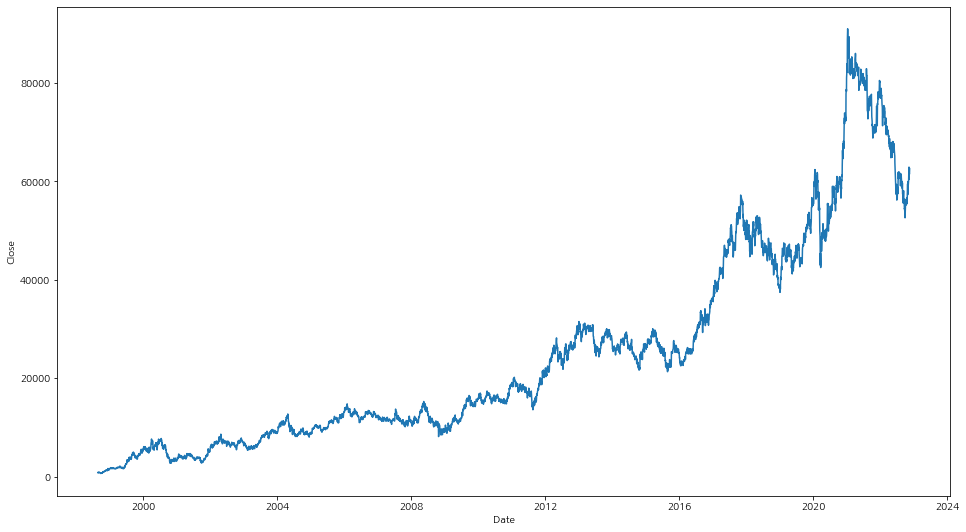

In [ ]:
plt.rcParams['font.family'] = 'NanumGothic'

plt.figure(figsize=(16, 9))
sns.lineplot(data=samsung, x='Date', y="Close")
plt.show()

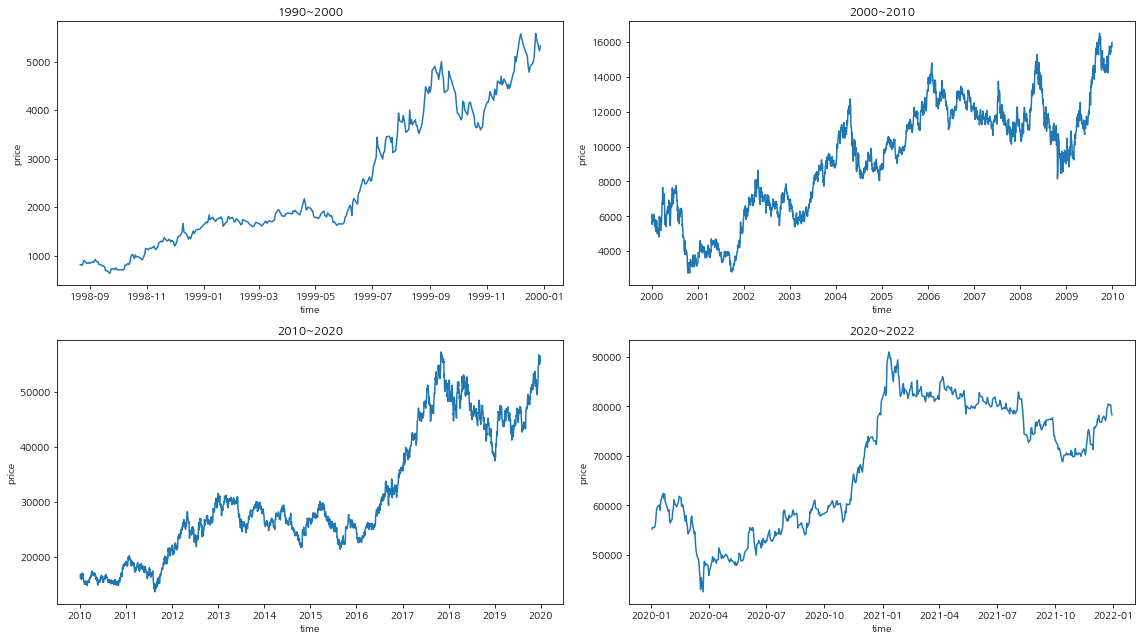

In [ ]:
time_steps = [['1990', '2000'], 
              ['2000', '2010'], 
              ['2010', '2020'], 
              ['2020', '2022']] # COVID-19

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)
for i in range(4):
    ax = axes[i//2, i%2]
    df = samsung.loc[(samsung.index > time_steps[i][0]) & (samsung.index < time_steps[i][1])]
    sns.lineplot(y=df['Close'], x=df.index, ax=ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

## 데이터 전처리

주가 데이터에 대하여 딥러닝 모델이 더 잘 학습할 수 있도록 **정규화(Normalization)**를 해주도록 하겠습니다.

**표준화 (Standardization)**와 **정규화(Normalization)**에 대한 내용은 아래 링크에서 더 자세히 다루니, 참고해 보시기 바랍니다.

- [데이터 전처리에 관하여](https://teddylee777.github.io/scikit-learn/scikit-learn-preprocessing)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Volume', 'Close']
# 스케일 후 columns
scaled = scaler.fit_transform(samsung[scale_cols])
scaled

array([[0.00947951, 0.00884298, 0.00898324, 0.00280092, 0.00196985],
       [0.00903654, 0.00850207, 0.00887151, 0.00473079, 0.00180386],
       [0.00894795, 0.00899793, 0.00902793, 0.00548778, 0.00231292],
       ...,
       [0.68881506, 0.64566116, 0.68826816, 0.13632496, 0.68349527],
       [0.6910299 , 0.64772727, 0.68938547, 0.14294991, 0.68681525],
       [0.68660022, 0.64049587, 0.6849162 , 0.07575294, 0.674642  ]])

스케일이 완료된 column으로 새로운 데이터프레임을 생성합니다.

**시간 순으로 정렬**되어 있으며, datetime index는 제외했습니다.

*6,000개의 row, 5개 column*으로 이루어진 데이터셋이 DataFrame으로 정리되었습니다.

In [ ]:
df = pd.DataFrame(scaled, columns=scale_cols, index=samsung.index)
df

,Open,High,Low,Volume,Close
Date,,,,,
1998-08-22,0.009480,0.008843,0.008983,0.002801,0.001970
1998-08-24,0.009037,0.008502,0.008872,0.004731,0.001804
1998-08-25,0.008948,0.008998,0.009028,0.005488,0.002313
1998-08-26,0.009546,0.009473,0.009520,0.012209,0.002877
1998-08-27,0.009845,0.009215,0.009654,0.005248,0.002689
...,...,...,...,...,...
2022-11-11,0.698782,0.652893,0.696089,0.221880,0.689029
2022-11-14,0.696567,0.649793,0.689385,0.176881,0.677962
2022-11-15,0.688815,0.645661,0.688268,0.136325,0.683495


## train / test 분할

- 2021년 이전까지의 모든 데이터로, 2022년을 예측해봅니다.


- 시계열 예측에서는 "예측 당시"에는 미래의 데이터를 모릅니다. 그래서 train 데이터는 무조건 test 데이터보다 시기적으로 **과거**여야합니다. 

In [ ]:
train = df.loc[(df.index > '2020-01-01') & (df.index < '2022-01-01')]
X_train, y_train = train.drop("Close", axis=1), train.Close
test = df.loc[df.index >= '2022-01-01']
X_test, y_test = test.drop("Close", axis=1), test.Close

In [ ]:
X_train

,Open,High,Low,Volume
Date,,,,
2020-01-02,0.614618,0.578512,0.614525,0.143880
2020-01-03,0.620155,0.584711,0.613408,0.170777
2020-01-06,0.607973,0.574380,0.610056,0.113823
2020-01-07,0.616833,0.582645,0.621229,0.110843
2020-01-08,0.622370,0.592975,0.624581,0.260239
...,...,...,...,...
2021-12-24,0.888151,0.834711,0.896089,0.133838
2021-12-27,0.892580,0.832645,0.891620,0.119409
2021-12-28,0.888151,0.830579,0.890503,0.201828


In [ ]:
y_test

Date
2022-01-03    0.862774
2022-01-04    0.863881
2022-01-05    0.849494
2022-01-06    0.843961
2022-01-07    0.859454
                ...   
2022-11-11    0.689029
2022-11-14    0.677962
2022-11-15    0.683495
2022-11-16    0.686815
2022-11-17    0.674642
Name: Close, Length: 216, dtype: float64

## Data Preparation

In [ ]:
import tensorflow as tf

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

Hyperparameter를 정의합니다.

In [ ]:
WINDOW_SIZE=10 # 20일 단위씩 학습
BATCH_SIZE=8  # 한번에 32개씩 학습

In [ ]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, False)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [ ]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (8, 10, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (8, 1)


## 모델

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh', input_shape=(WINDOW_SIZE, 1)),
    Dense(16, activation="relu"),
    Dense(1)
])

In [ ]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 MSE()를 사용합니다.
loss_fn = 'mean_squared_error'
optimizer = Adam(learning_rate=0.0001)
model.compile(loss=loss_fn, optimizer=optimizer, metrics=['mse'])

In [ ]:
# val_loss 기준 체크포인터도 생성합니다.
filename = "best_model.ckpt"
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

In [ ]:
history = model.fit(train_data,
                    validation_data=(test_data),
                    epochs=1000,
                    callbacks=[checkpoint])

Epoch 1/1000
     61/Unknown - 9s 10ms/step - loss: 0.2856 - mse: 0.2856
Epoch 1: val_loss improved from inf to 0.16611, saving model to best_model.ckpt
61/61 [==============================] - 13s 61ms/step - loss: 0.2856 - mse: 0.2856 - val_loss: 0.1661 - val_mse: 0.1661
Epoch 2/1000
61/61 [==============================] - ETA: 0s - loss: 0.1310 - mse: 0.1310
Epoch 2: val_loss improved from 0.16611 to 0.05342, saving model to best_model.ckpt
61/61 [==============================] - 1s 18ms/step - loss: 0.1310 - mse: 0.1310 - val_loss: 0.0534 - val_mse: 0.0534
Epoch 3/1000
58/61 [===========================>..] - ETA: 0s - loss: 0.0312 - mse: 0.0312
Epoch 3: val_loss improved from 0.05342 to 0.00220, saving model to best_model.ckpt
61/61 [==============================] - 1s 18ms/step - loss: 0.0304 - mse: 0.0304 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 4/1000
58/61 [===========================>..] - ETA: 0s - loss: 0.0025 - mse: 0.0025
Epoch 4: val_loss improved from 0.00220 to 0.

저장한 ModelCheckpoint 를 로드합니다.

In [ ]:
model.load_weights(filename)

`test_data`를 활용하여 예측을 진행합니다.

In [ ]:
pred = model.predict(test_data)

26/26 [==============================] - 1s 5ms/step


In [ ]:
pred.shape

(206, 1)

## 예측 데이터 시각화

아래 시각화 코드중 y_test 데이터에 **[WINDOW_SIZE:]**으로 슬라이싱을 한 이유는

예측 데이터에서 WINDOW_SIZE일치의 데이터로 WINDOW_SIZE+1일치를 예측해야하기 때문에 test_data로 예측 시 *앞의 WINDOW_SIZE일은 예측하지 않습니다.*

따라서, index WINDOW_SIZE와 비교하면 더욱 정확합니다.

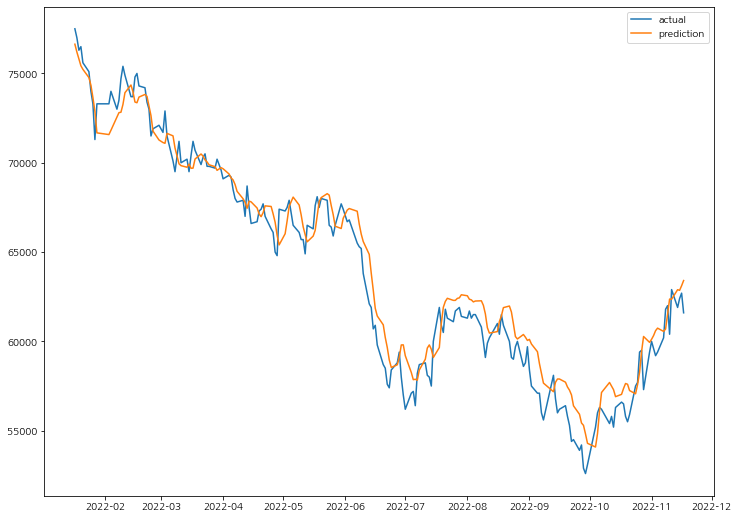

In [ ]:
temp = np.hstack([X_test[WINDOW_SIZE:], pred])
temp2 = np.hstack([X_test[WINDOW_SIZE:], y_test.values.reshape(-1, 1)[WINDOW_SIZE:]])

preds = scaler.inverse_transform(temp)
preds2 = scaler.inverse_transform(temp2)
preds = preds[:, -1]
label = preds2[:, -1]

plt.figure(figsize=(12, 9))
plt.plot(X_test[WINDOW_SIZE:].index, label, label='actual')
plt.plot(X_test[WINDOW_SIZE:].index, preds, label='prediction')
plt.legend()
plt.show()